In [1]:
import os
import cv2
import torch
import pandas as pd
import numpy as np

from torch import nn

from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
from transformers import SegformerForSemanticSegmentation

import matplotlib.pyplot as plt
%matplotlib inline

2023-06-01 10:51:56.287074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:51:56.850442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from loss import dice_coef_loss, tversky_index_loss, TverskyIndexLoss
from ImageDataset import ImageDataset, get_img_for_train_and_val, collate_fn
from imgPrepare import img_prepare, create_img_transform
from smallModel import SmallSegFormer
from wideSegFormer import WideSegFormer, SegformerDecodeHead
from learning_loop import learning_loop, show_examples
from train_model import create_model_and_optimizer, load_model_and_create_optimizer
%load_ext autoreload
%autoreload 2

In [3]:
img_size_for_model = 512
annotate = False
img_transform = create_img_transform(img_size_for_model, val=True, annotate = annotate)
img_transform_val = create_img_transform(img_size_for_model, val=True, annotate = annotate)
train, test = get_img_for_train_and_val("data")

In [4]:
dataset_train = ImageDataset(train, img_prepare, img_transform, annotate)
dataset_test = ImageDataset(test, img_prepare, img_transform_val, annotate)

In [5]:
len(dataset_train), len(dataset_test)

(1383, 129)

In [6]:
class TwinSegFormer(nn.Module):
    def __init__(self, device="cpu"):
        super(TwinSegFormer, self).__init__()
        self.handSegFormer, _ = load_model_and_create_optimizer(
            model_class = SmallSegFormer,
            model_params = {
                "freeze_encoder": True, 
                "segFormerNumber": 2
            },
            model_name = "handModel3",
            device = device,
            epoch = 38,
            lr=1e-5
        )
        self.handSegFormer = self.handSegFormer.segFormer.segformer
        
        self.bodySegFormer, _ = load_model_and_create_optimizer(
                model_class = SmallSegFormer,
                model_params = {
                    "freeze_encoder": False, 
                    "segFormerNumber": 2
                },
                model_name = "bodyModel",
                device = device,
                epoch = 46,
                lr=1e-5
        )
        self.bodySegFormer = self.bodySegFormer.segFormer.segformer
        self.decode_head = SegformerDecodeHead(1).to(device)
    
    def forward(self, x):
        x = x.float() / 255
        emb_hand = self.handSegFormer(x, output_hidden_states=True)
        emb_body = self.bodySegFormer(x, output_hidden_states=True)
        
        emb = []
        for i in range(4):
            emb.append(torch.concat([emb_hand.hidden_states[i], emb_body.hidden_states[i]], dim=1))

        output = self.decode_head(emb)
        return output

In [7]:
batch_size = 4

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [8]:
def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for imgs_batch, mask_batch in tqdm(loader):
        optimizer.zero_grad()
        imgs_batch = imgs_batch.to(device)
        mask_batch = mask_batch.to(device)
        pred = model(imgs_batch)
        pred = nn.functional.sigmoid(pred.permute(0, 2, 3, 1))
        pred = pred.view(pred.shape[0], pred.shape[1], -1)
        loss = criterion(pred, mask_batch)
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for imgs_batch, mask_batch in tqdm(loader):
            imgs_batch = imgs_batch.to(device)
            mask_batch = mask_batch.to(device)
            pred = model(imgs_batch)
            pred = nn.functional.sigmoid(pred.permute(0, 2, 3, 1))
            pred = pred.view(pred.shape[0], pred.shape[1], -1)
            loss = criterion(pred, mask_batch)
            losses_val.append(loss.item())
            
            if metric_names is not None:
                if 'diceCoefficient' in metric_names:
                    metrics['diceCoefficient'].append(
                            dice_coef_loss((pred >= 0.5).long(), mask_batch, reverse=True).item()
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    return np.mean(losses_val), metrics if metric_names else None

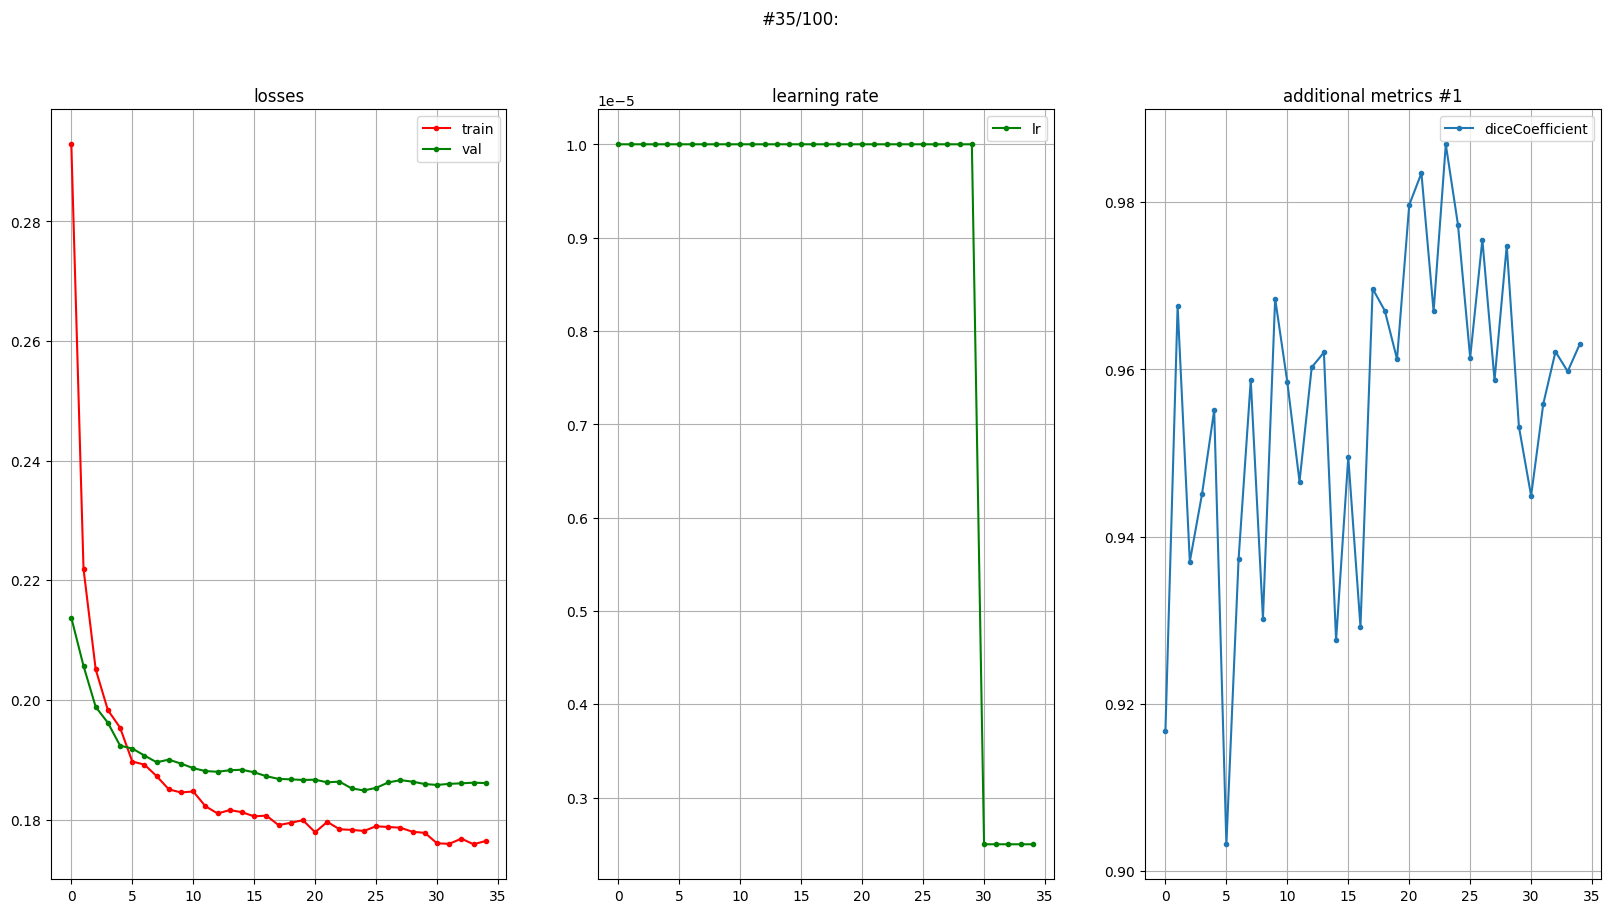

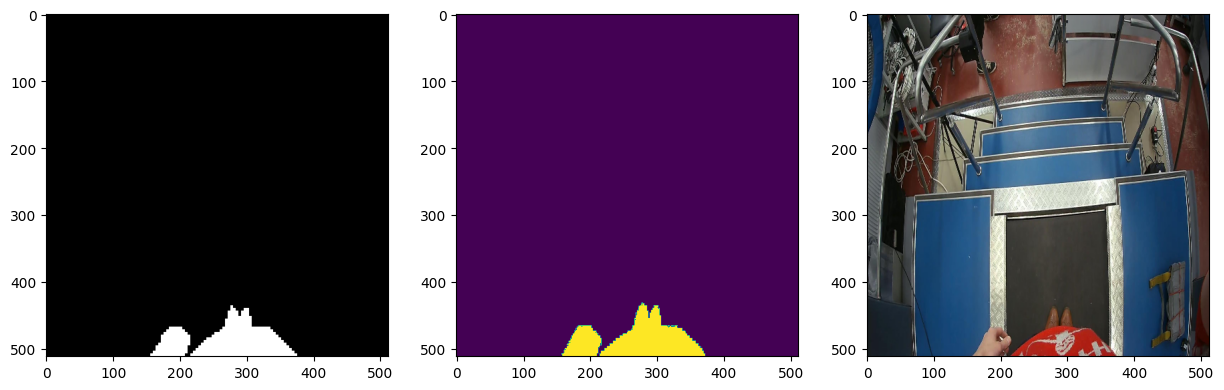

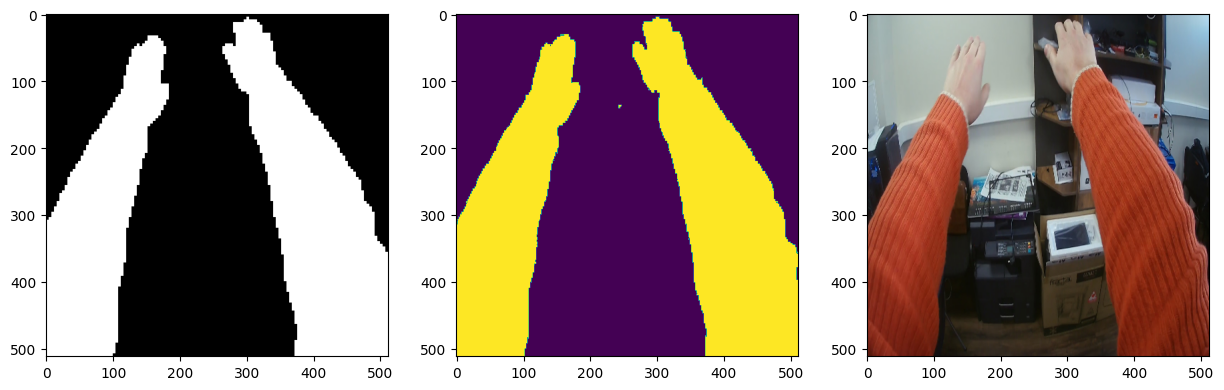

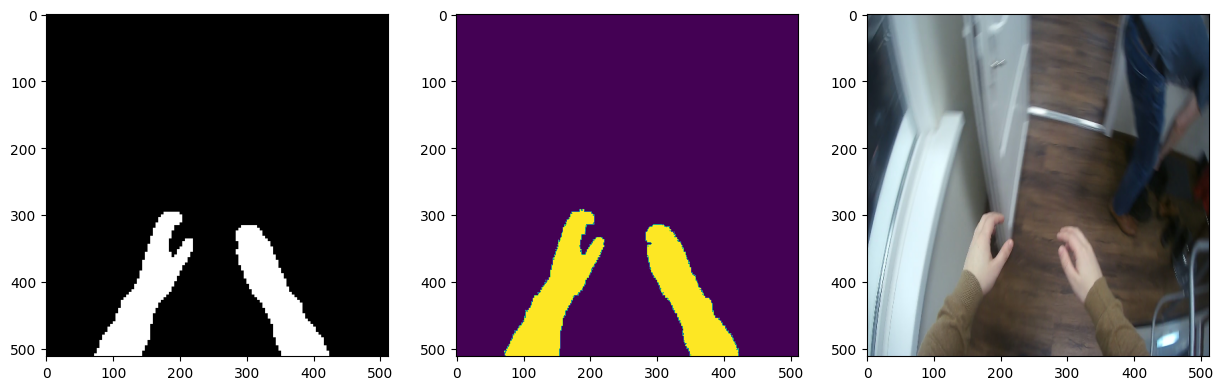

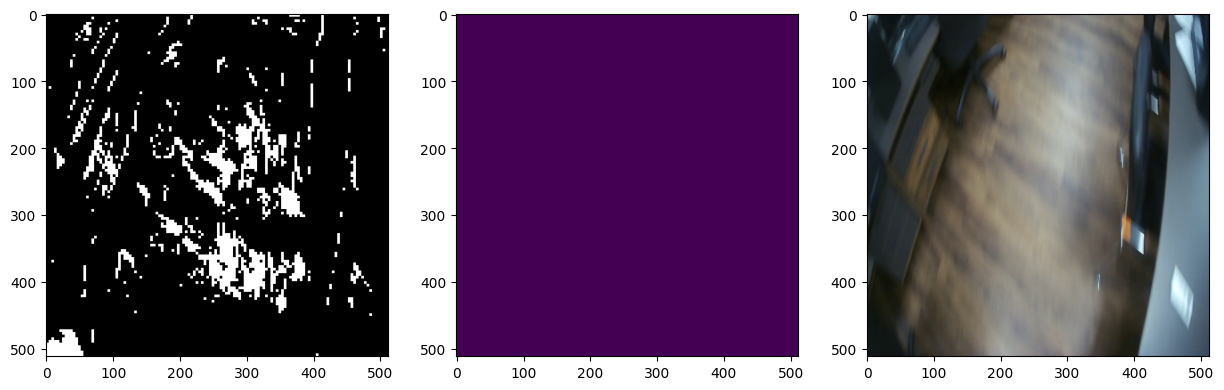

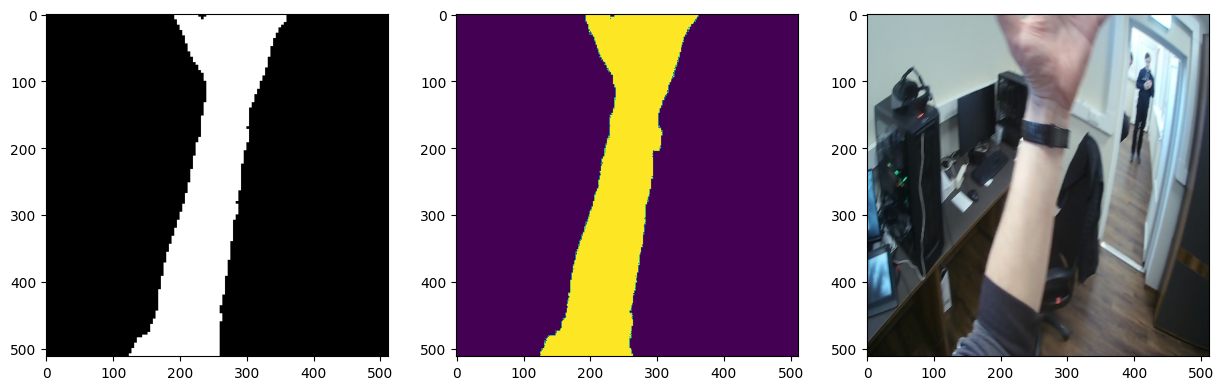

Learning process ended with early stop after epoch 35
CPU times: user 10h 52min 58s, sys: 59min, total: 11h 51min 58s
Wall time: 2h 25min 23s


In [9]:
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
model, optimizer = create_model_and_optimizer(
    model_class = TwinSegFormer,
    model_params = {
        "device": device,
    },
    device = device,
    lr=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

a = 0.3
criterion = TverskyIndexLoss(a, 1 - a)
every = 1
model, optimizer, losses = learning_loop(
    train,
    val,
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 100,
    min_lr = 1e-6,
    val_every = every,
    draw_every = every,
    separate_show = False,
    metric_names = {
        "diceCoefficient": {"plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "finalModel2",
    test_dataset = dataset_test
)

In [10]:
chkp_folder = "./chkp"
epoch = 35
model_name = "finalModel2"
torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name, f'{model_name}#{epoch}.pt'),
                )

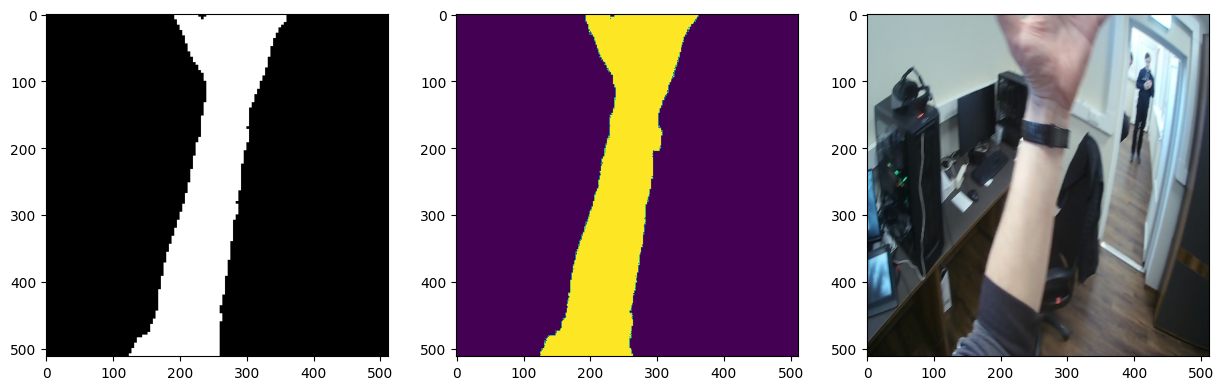

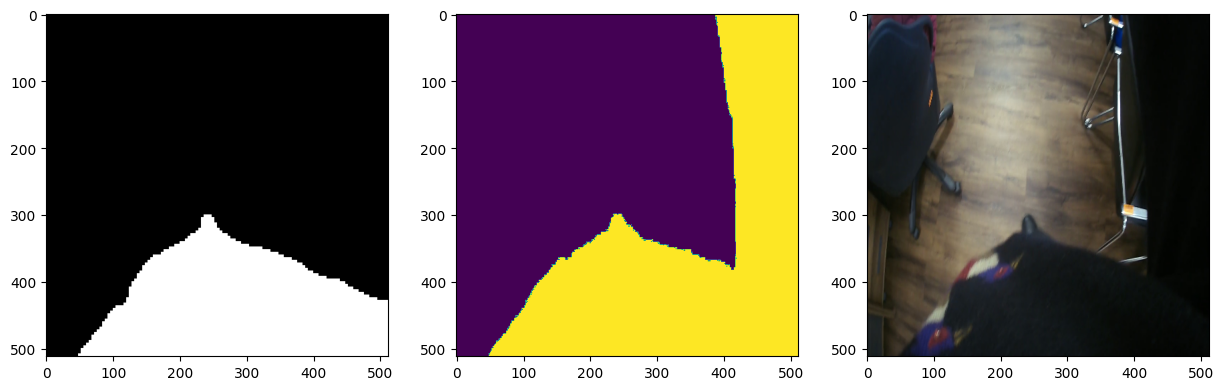

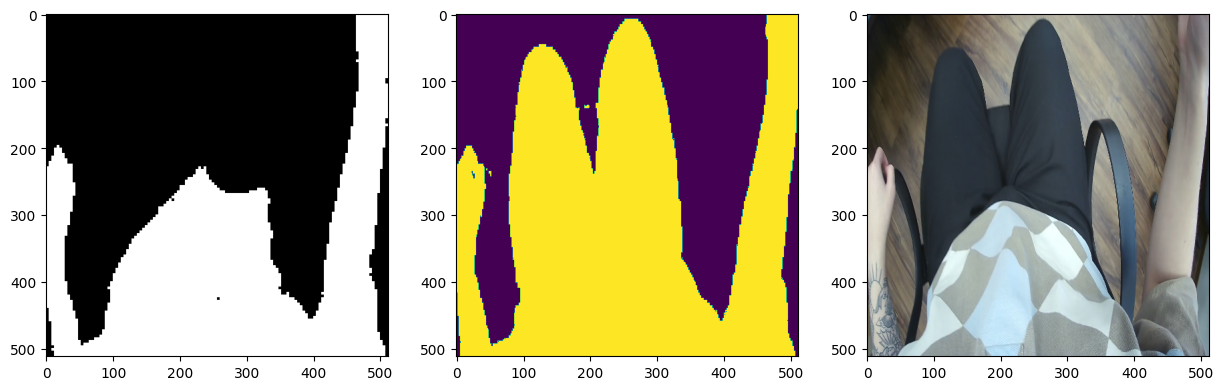

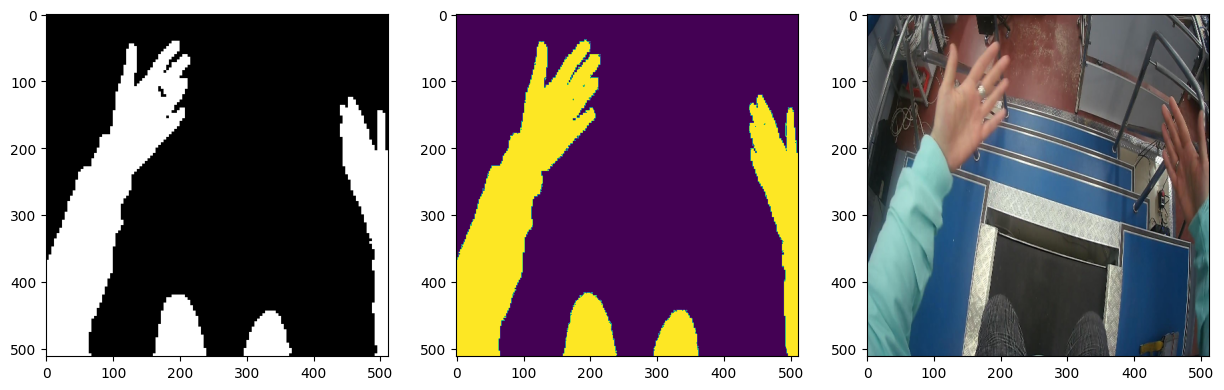

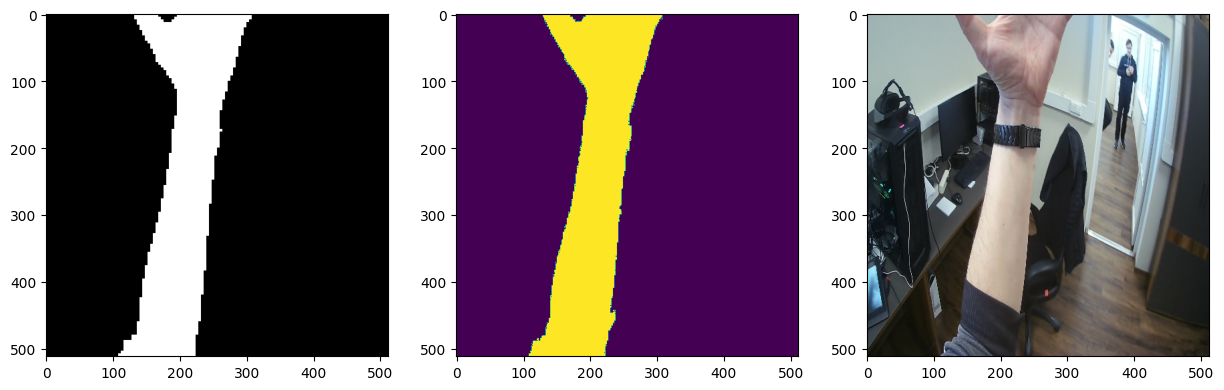

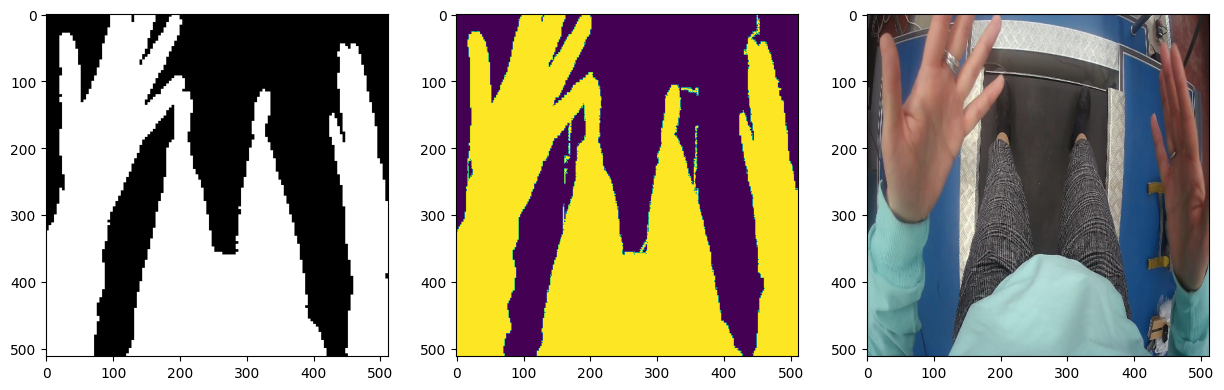

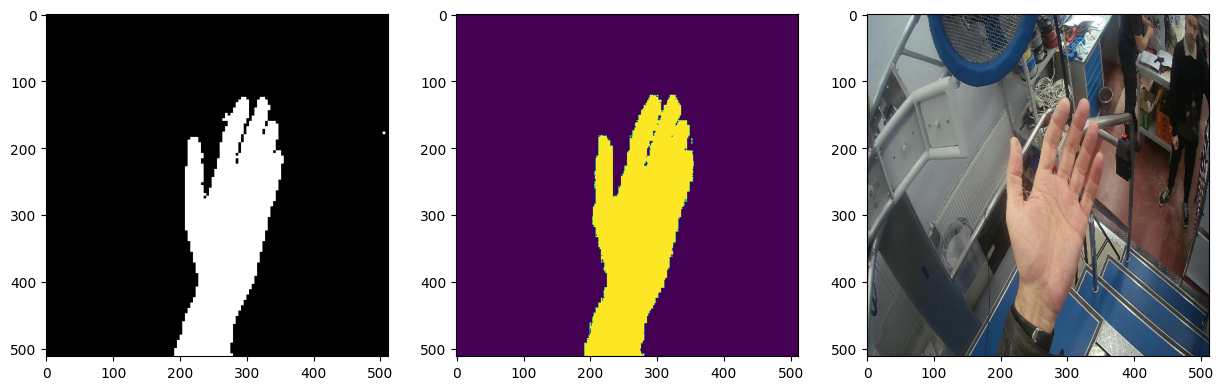

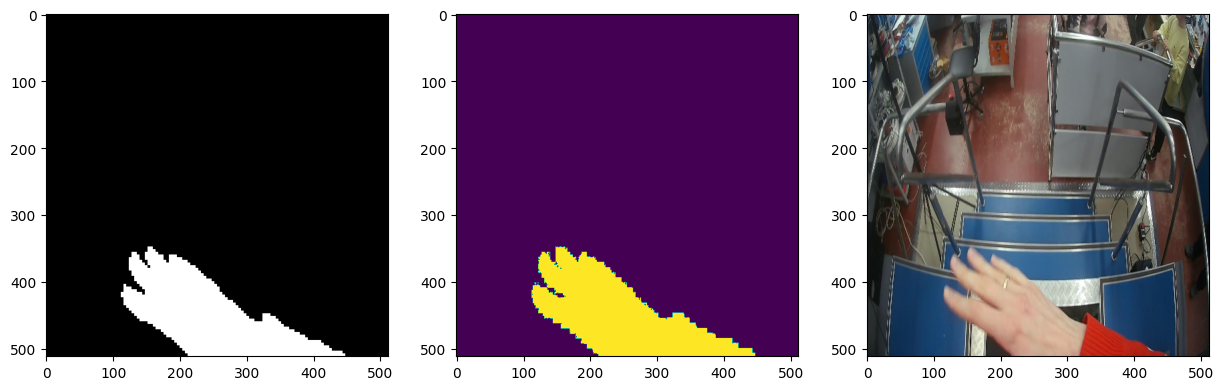

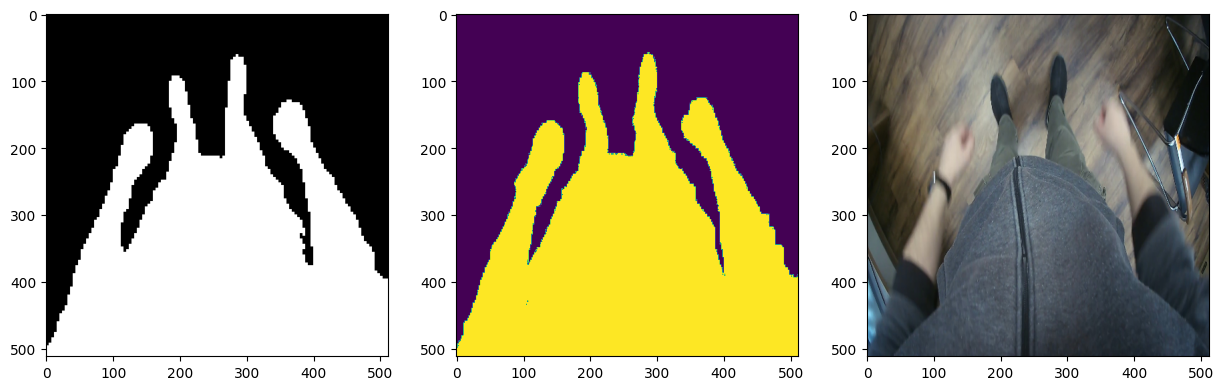

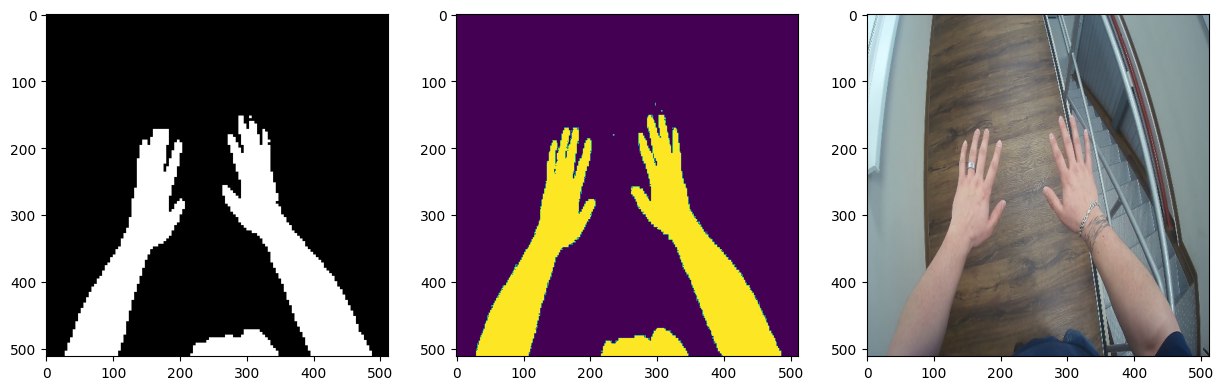

In [11]:
show_examples(10, dataset_test, model)

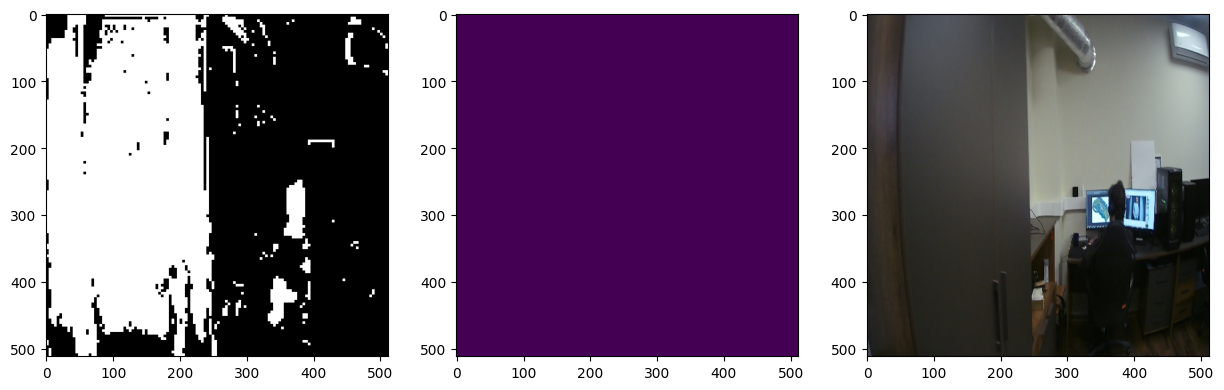

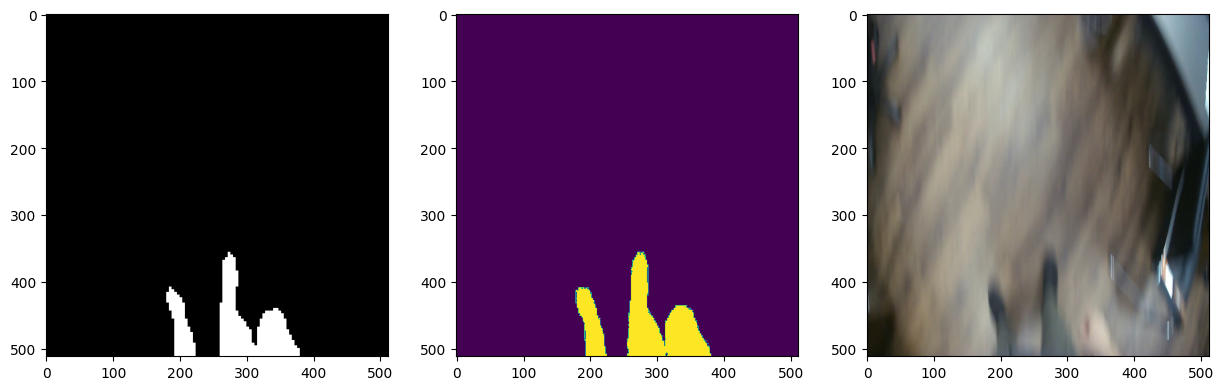

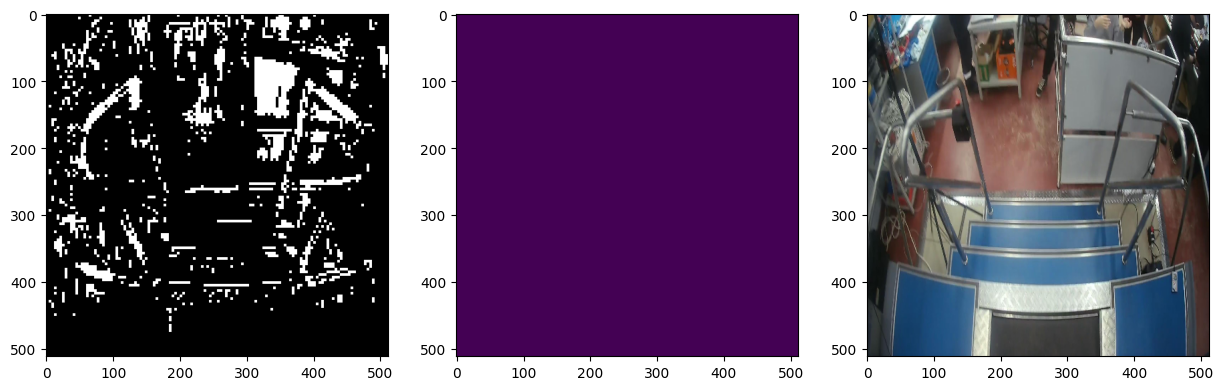

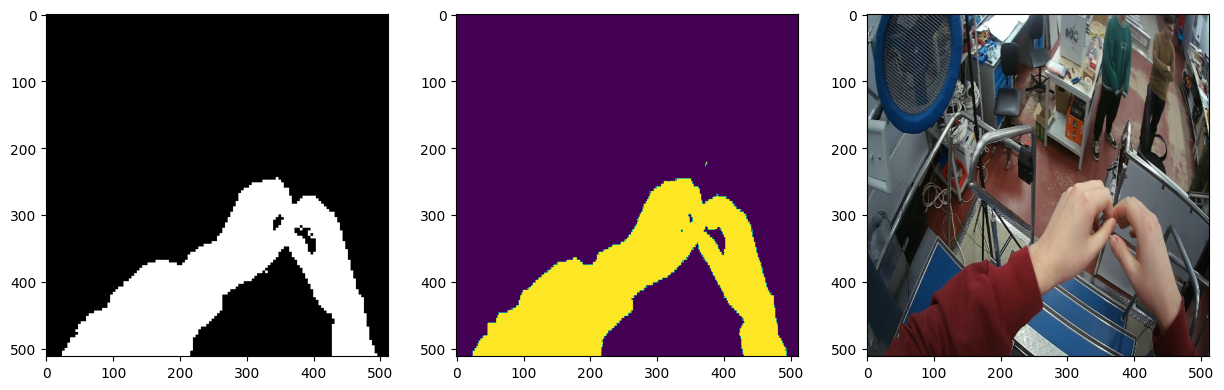

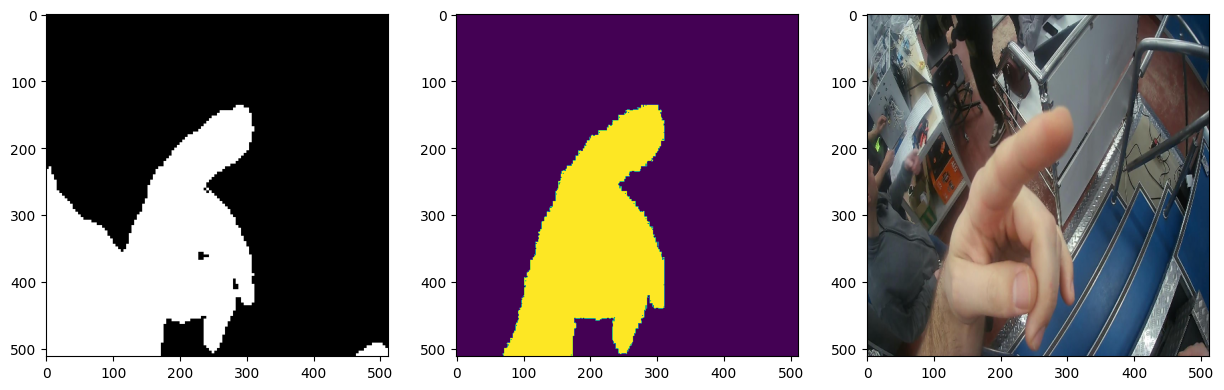

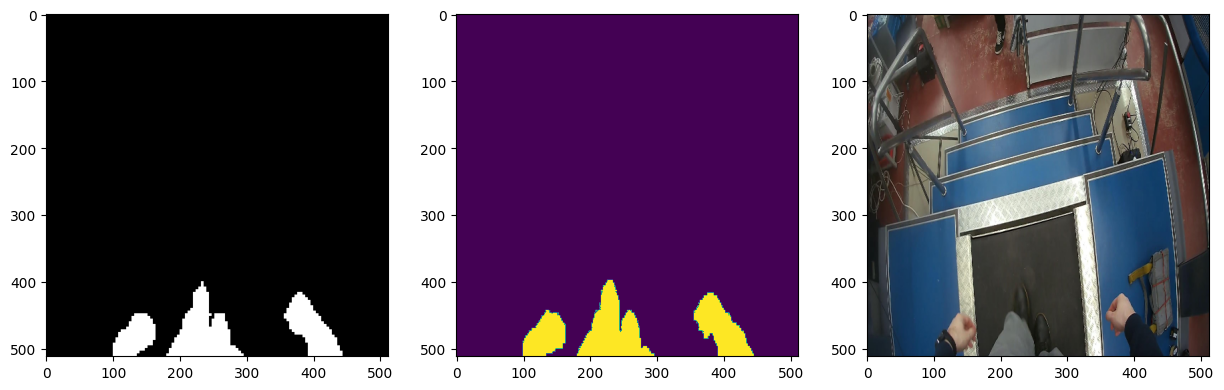

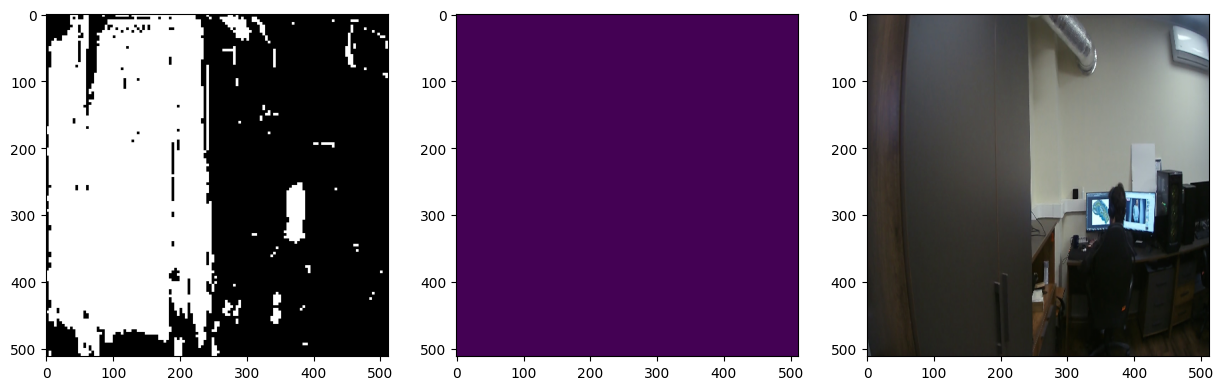

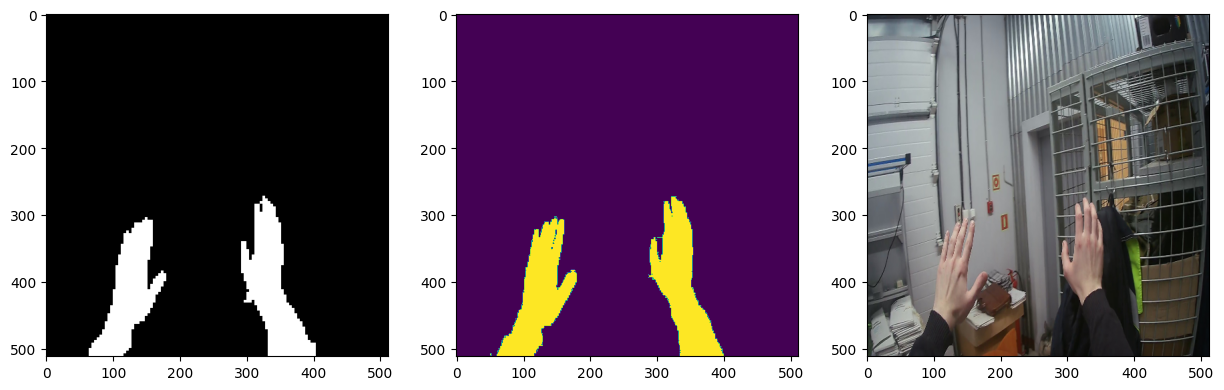

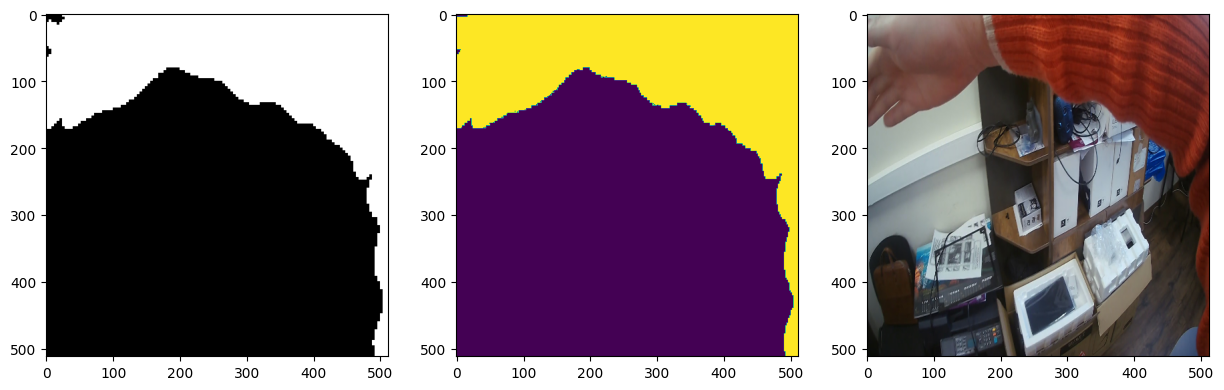

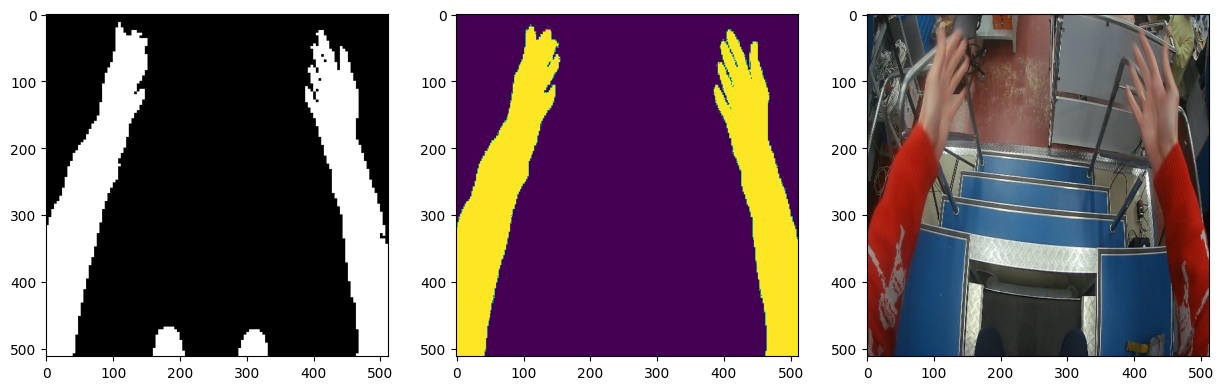

In [12]:
show_examples(10, dataset_test, model)

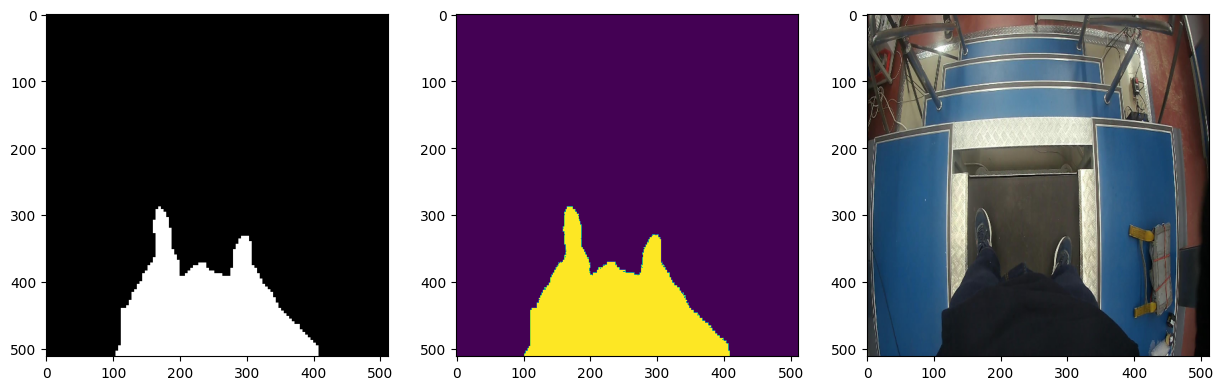

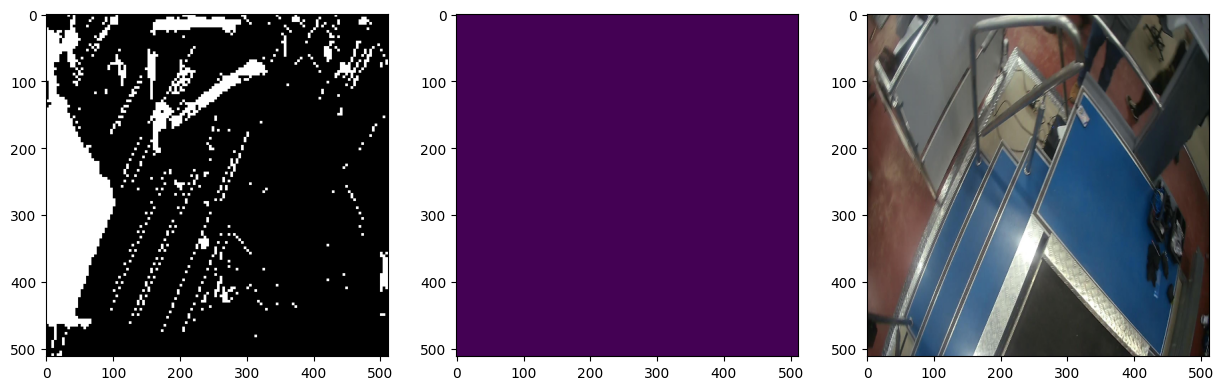

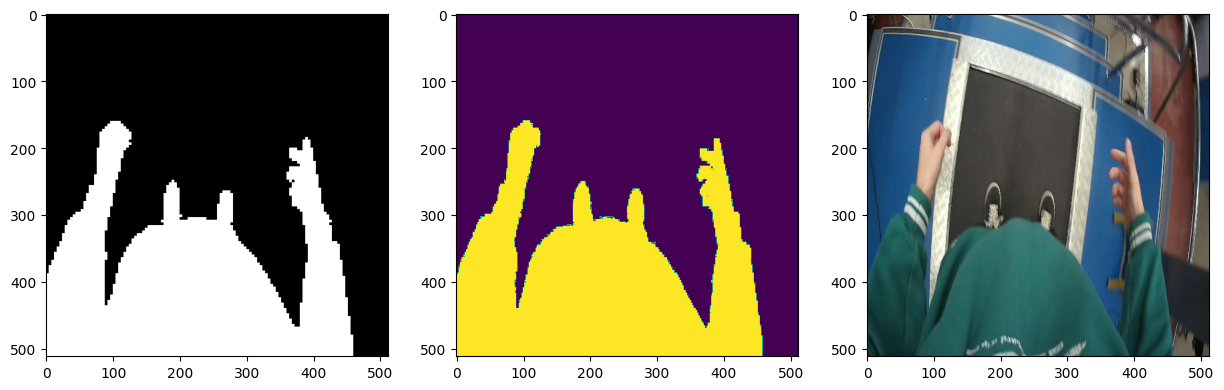

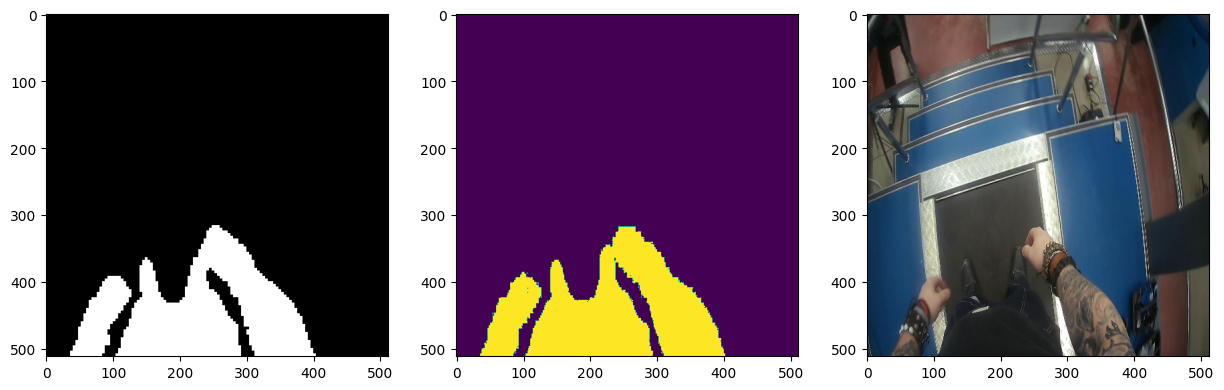

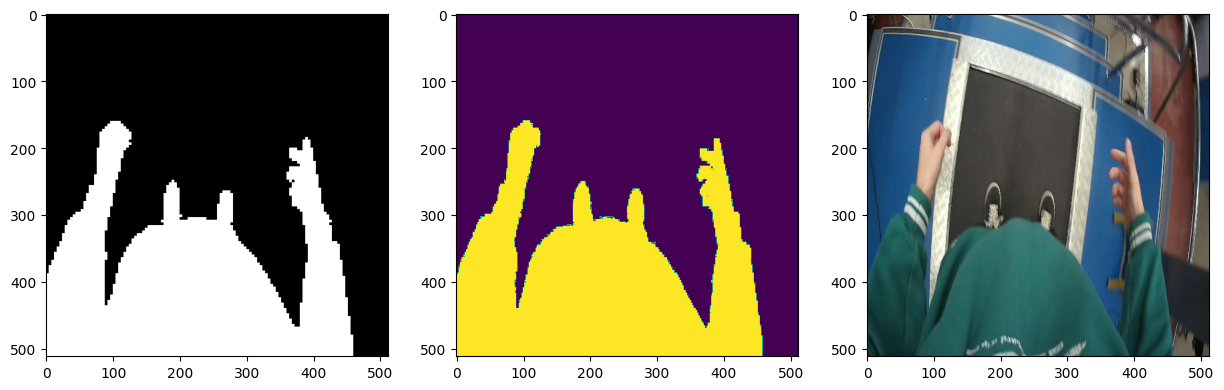

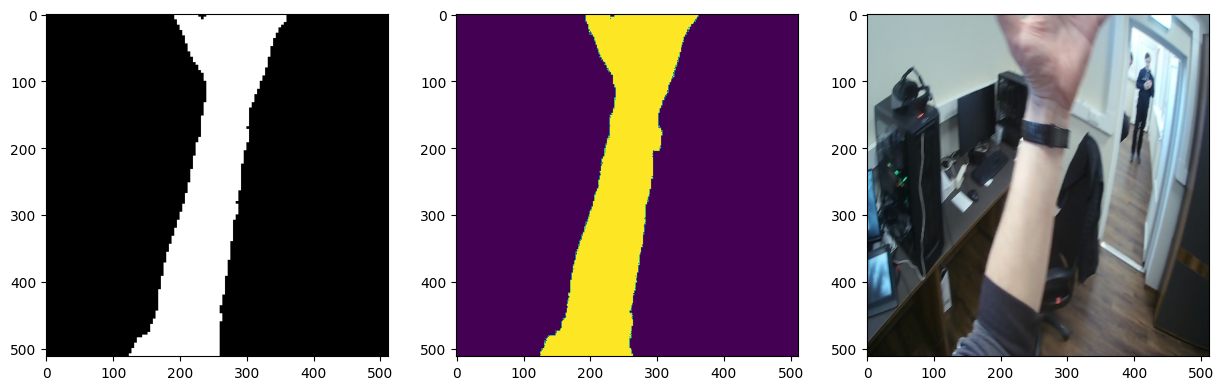

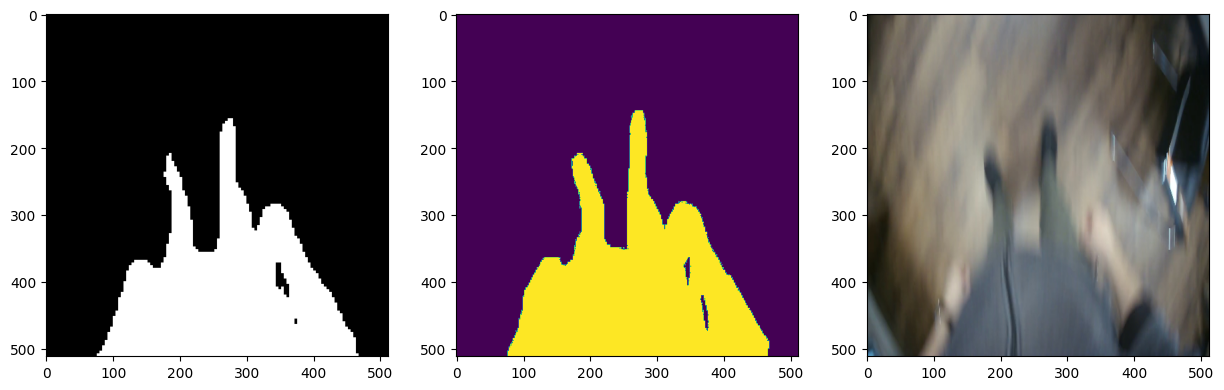

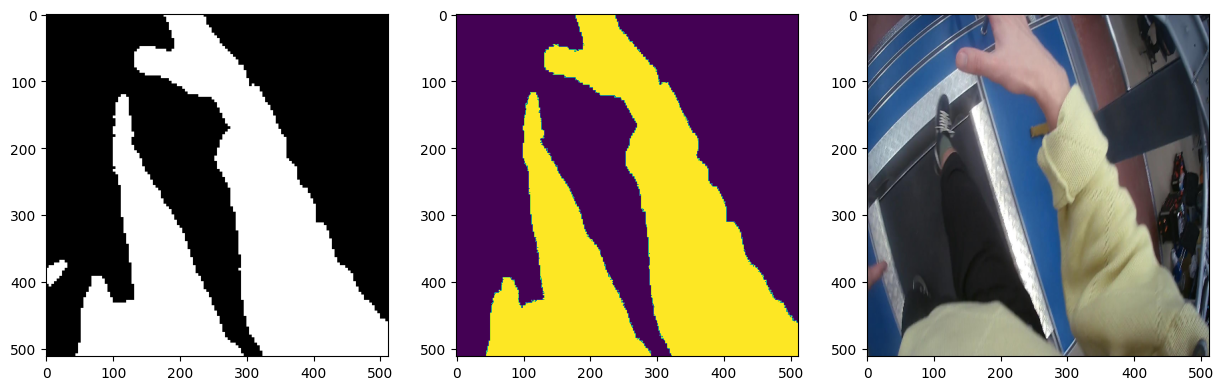

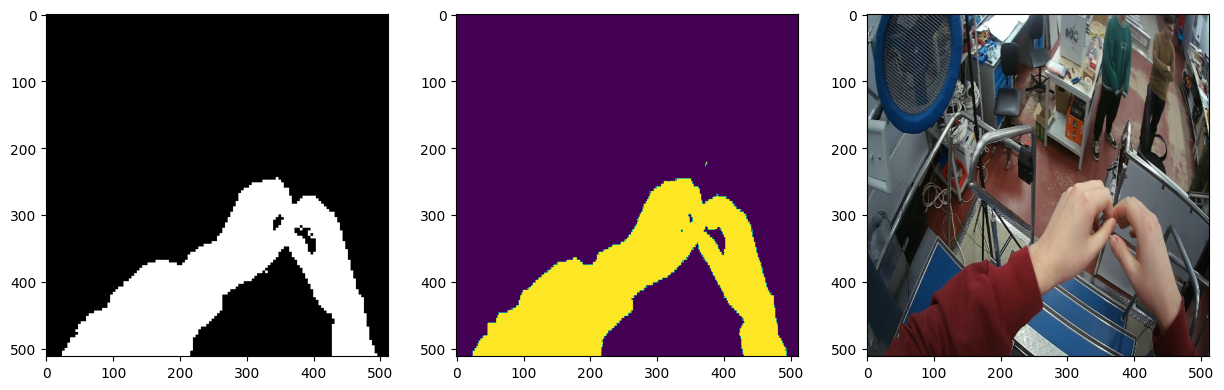

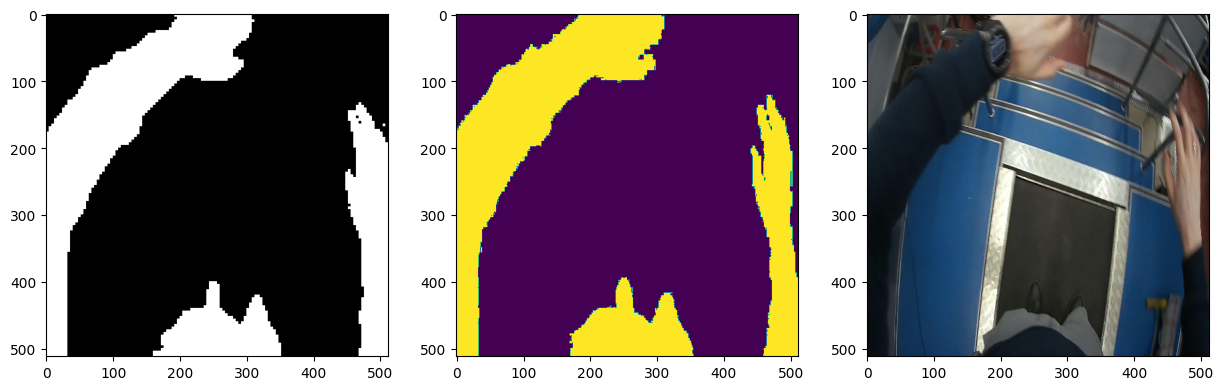

In [13]:
show_examples(10, dataset_test, model)